In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_output, compute_factor
from solver import train
from utils import compose, svd

In [6]:
key = PRNGKey(0)

input_dim = 20
output_dim = 20
rank = 2
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, input_dim), rank=rank)

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_output)

In [7]:
n_outer_loops = 100
step_size = 1e-1
result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=step_size
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
V1 = compute_factor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=rank)
U1 = init_weights[0] @ V1 / init_scale

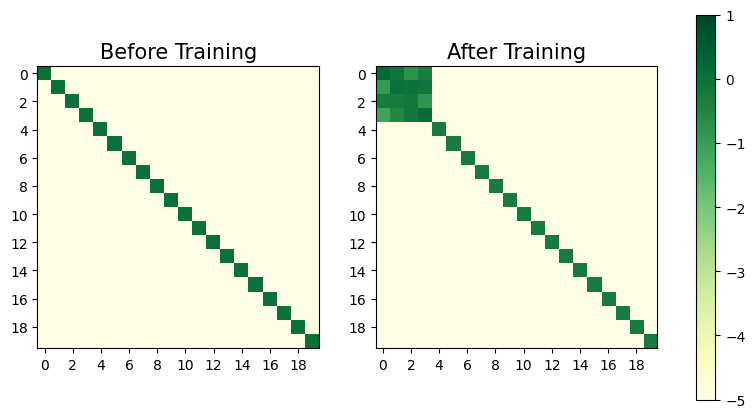

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes[0].imshow(jnp.log10(jnp.abs(U1.T @ init_weights[0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
axes[0].set_title('Before Training', fontsize=15)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

pcm = axes[1].imshow(jnp.log10(jnp.abs(U1.T @ result['final_weights'][0] @ V1)), cmap='YlGn', vmax=1, vmin=-5)
axes[1].set_title('After Training', fontsize=15)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(pcm, ax=axes.ravel().tolist())
plt.savefig('figs/thm_main.png', dpi=300, bbox_inches='tight')